# Initial Data Analysis

The goal of this notebook is to visualize the transformed data that we have from the spark cluster. See what we have, and what to do next.

In [1]:
import pandas as pd
import numpy as np
import glob
import os

In [2]:
# read in the transformed data
all_files = glob.glob(os.path.join('submissions-transformed/', '*.json.gz'))

submissions = pd.concat((pd.read_json(f, lines=True) for f in all_files))

In [3]:
submissions.dtypes

created_on       int64
age              int64
year             int64
month            int64
day              int64
hour             int64
day_of_week      int64
subreddit       object
author          object
post_count       int64
over_18          int64
gilded           int64
archived         int64
quarantine       int64
stickied         int64
num_comments     int64
score            int64
title_length     int64
title           object
selftext        object
dtype: object

## 1. Overall Summary Statistics

In [4]:
# 257121 number of submissions in dataset
submissions.shape

(6802204, 20)

In [5]:
# View summary stats
submissions[['score', 'num_comments']].describe()

,score,num_comments
count,6.802204e+06,6.802204e+06
mean,3.784474e+01,1.281894e+01
std,1.106914e+03,2.696671e+02
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,3.000000e+00
75%,3.000000e+00,8.000000e+00
max,2.027170e+05,7.586000e+04


# 2. Visualizations of Data

In [6]:
import matplotlib.pyplot as plt

### 2.1 Distribution of Score and Comments

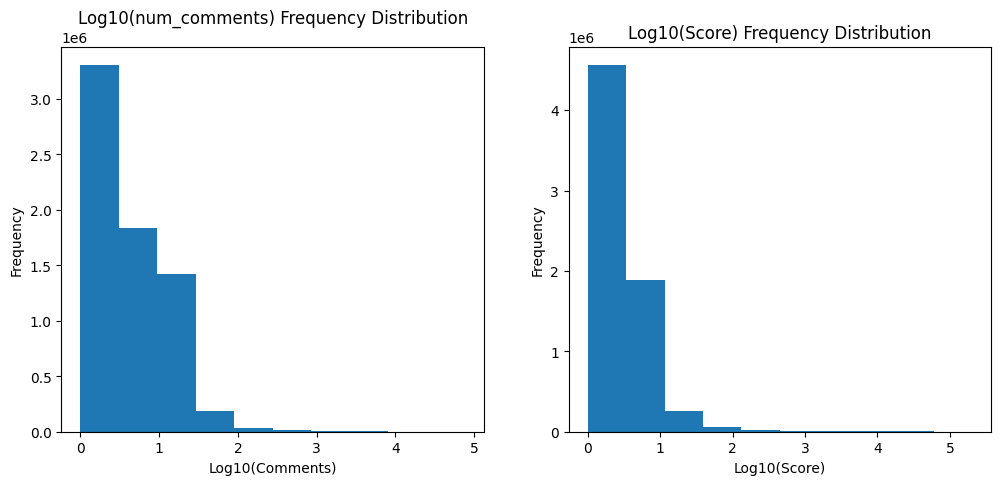

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# axes[0].hist(submissions['score'])
# axes[0].set_title('Score Frequency Distribution')
# axes[0].set_xlabel('Score')
# axes[0].set_ylabel('Frequency')

# axes[0].hist(submissions['num_comments'])
# axes[0].set_title('num_comments Frequency Distribution')
# axes[0].set_xlabel('Number of Comments')
# axes[0].set_ylabel('Frequency')

scores = submissions['score'].values
scores = np.log10(scores + 1)
axes[1].hist(scores)
axes[1].set_title('Log10(Score) Frequency Distribution')
axes[1].set_xlabel('Log10(Score)')
axes[1].set_ylabel('Frequency')

comments = submissions['num_comments'].values
comments = np.log10(comments + 1)
axes[0].hist(comments)
axes[0].set_title('Log10(num_comments) Frequency Distribution')
axes[0].set_xlabel('Log10(Comments)')
axes[0].set_ylabel('Frequency')

fig.show()
fig.savefig('./figures/2.1-dist-score-comments.jpg')

### 2.2 Scatter Plots: time vs score and time vs comments

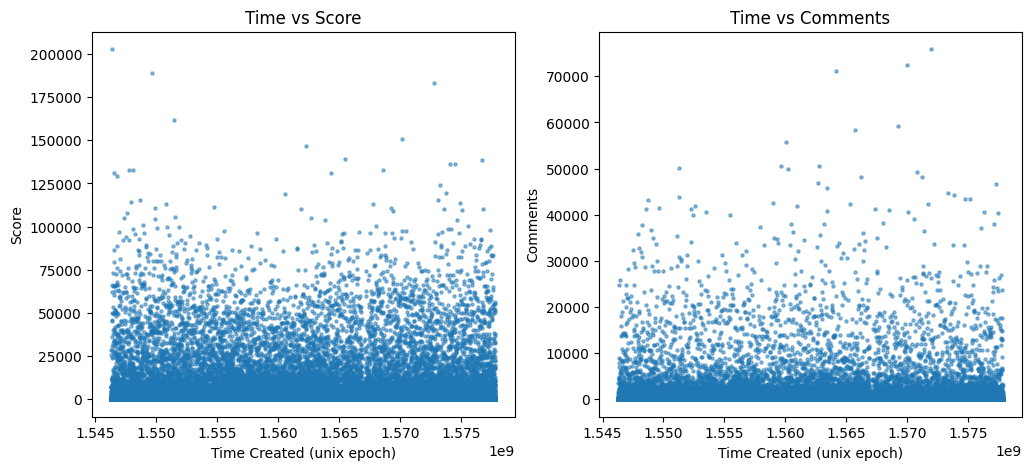

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(submissions['created_on'], submissions['score'], alpha=0.5, s=5 )
axes[0].set_title('Time vs Score')
axes[0].set_xlabel('Time Created (unix epoch)')
axes[0].set_ylabel('Score')

axes[1].scatter(submissions['created_on'], submissions['num_comments'], alpha=0.5, s=5 )
axes[1].set_title('Time vs Comments')
axes[1].set_xlabel('Time Created (unix epoch)')
axes[1].set_ylabel('Comments')

fig.show()
fig.savefig('./figures/2.2-scatter-time-score-comments.jpg')


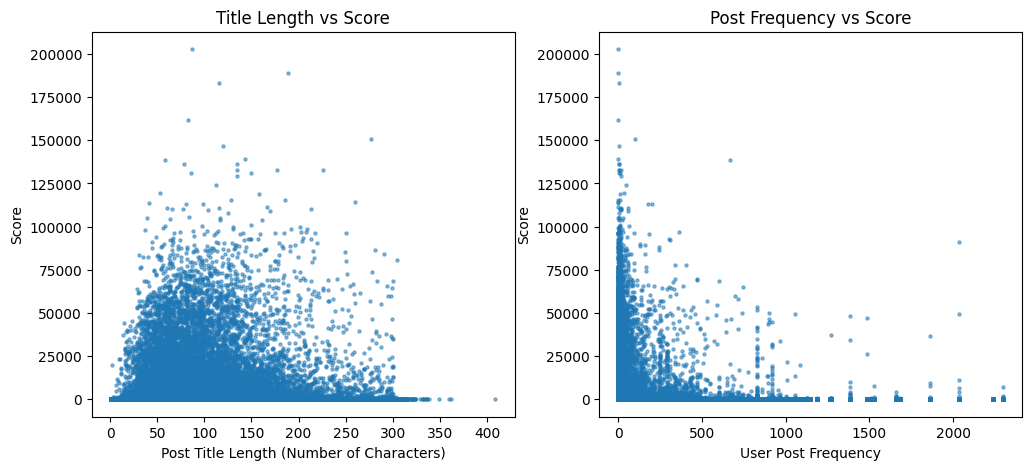

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(submissions['title_length'], submissions['score'], alpha=0.5, s=5 )
axes[0].set_title('Title Length vs Score')
axes[0].set_xlabel('Post Title Length (Number of Characters)')
axes[0].set_ylabel('Score')

filtered = submissions[submissions['author'] != '[deleted]']
# Users posting more than 3k likely bots...
filtered = filtered[filtered['post_count'] < 3000]
axes[1].scatter(filtered['post_count'], filtered['score'], alpha=0.5, s=5 )
axes[1].set_title('Post Frequency vs Score')
axes[1].set_xlabel('User Post Frequency')
axes[1].set_ylabel('Score')

fig.show()
fig.savefig('./figures/2.2-scatter-title-postfreq-score.jpg')

## 3. Analysis of Data Skewness


- Measures such as score and num_comments is heavily right skewed (based on the dataframe describe and histogram visualizations)
- A large majority of reddit submissions are seen as "not good".
- 99% of our data are submissions with score less than 70
- Only 1% of data have scores over 70

In [10]:
submissions['score'].quantile(0.99)

70.0

In [11]:
ninety_nine = submissions[submissions['score'] <= 70] 
one_percent = submissions[submissions['score'] > 70]

In [12]:
ninety_nine[['score', 'num_comments']].describe()

,score,num_comments
count,6.734718e+06,6.734718e+06
mean,2.946302e+00,6.447358e+00
std,5.133704e+00,1.208206e+01
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,3.000000e+00
75%,3.000000e+00,8.000000e+00
max,7.000000e+01,1.064000e+03


In [13]:
one_percent[['score', 'num_comments']].describe()

,score,num_comments
count,67486.000000,67486.000000
mean,3520.509483,648.666790
std,10547.393463,2628.112555
min,71.000000,0.000000
25%,114.000000,14.000000
50%,242.000000,49.000000
75%,1192.000000,310.000000
max,202717.000000,75860.000000


### 3.1 Looking at Submissions in the Top 1% of Score

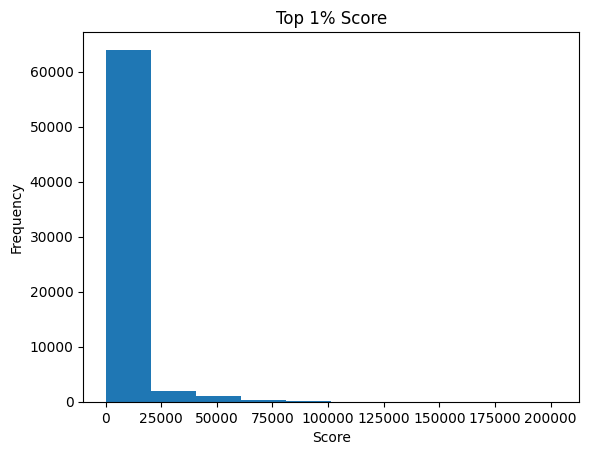

In [14]:
plt.hist(one_percent['score'])
plt.title('Top 1% Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('./figures/3.1-dist-top-one-percent-score.jpg')
plt.show()

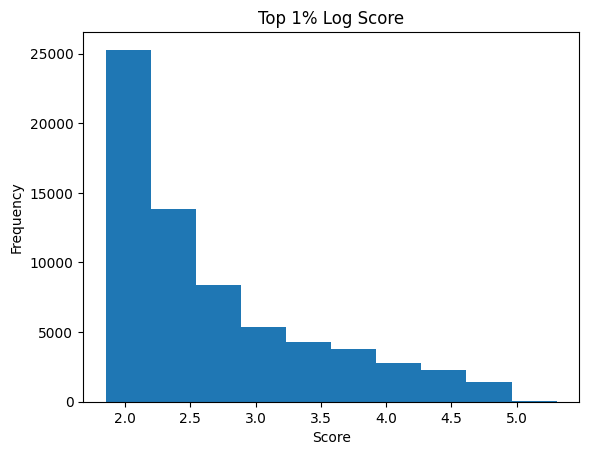

In [15]:
transformed_one_percent = one_percent['score'].values
transformed_one_percent = np.log10(transformed_one_percent)
plt.hist(transformed_one_percent)
plt.title('Top 1% Log Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('./figures/3.1-dist-top-one-percent-log-score.jpg')
plt.show()


### 3.2 Looking at Submissions in the Top 0.1% of Score

In [16]:
submissions['score'].quantile(0.999)

7982.797000001185

In [17]:
zero_one_percent = one_percent[one_percent['score'] > 7990]
zero_one_percent[['score', 'num_comments']].describe()

,score,num_comments
count,6797.000000,6797.000000
mean,28008.082978,4060.862292
std,20498.736515,7192.028232
min,7991.000000,51.000000
25%,12538.000000,318.000000
50%,20995.000000,667.000000
75%,38036.000000,4659.000000
max,202717.000000,75860.000000


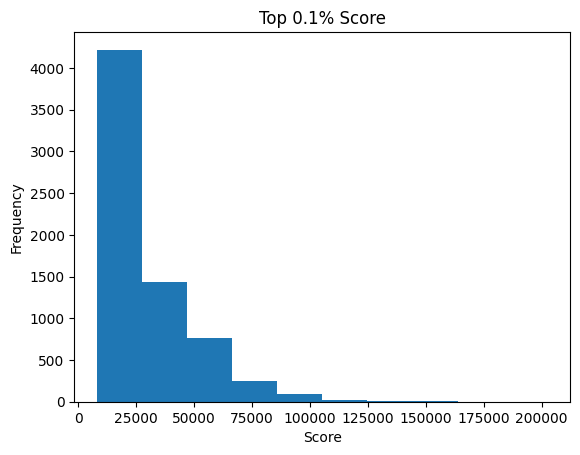

In [18]:
plt.hist(zero_one_percent['score'])
plt.title('Top 0.1% Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('./figures/3.2-dist-top-zero-one-percent-score.jpg')
plt.show()

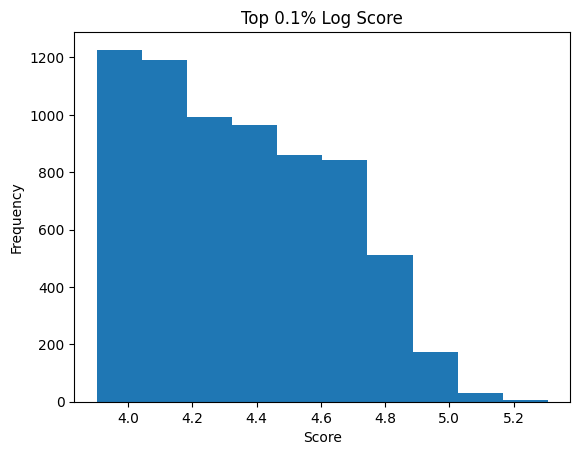

In [19]:
transformed_one_percent = zero_one_percent['score'].values
transformed_one_percent = np.log10(transformed_one_percent)
plt.hist(transformed_one_percent)
plt.title('Top 0.1% Log Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('./figures/3.2-dist-top-zero-one-percent-log-score.jpg')
plt.show()

# 4. Next Steps

Where do we go from here?  

The submissions score distribution is heavily skewed. A large portion of submissions are concentrated near the bottom 99%.  
Only a very few posts can be considered "good".  

To somewhat balance this skewed dataset, we will derive two major sub groups of submissions by splitting the data long the mean score.  
The group of submissions belonging to below the mean will clearly be the majority group.  
As a solution, we will keep all submissions above the mean (as above average posts) and subsample the bottom majority.  


In [20]:
# Clear all previous temp data frames to reduce memory usage
del one_percent
del ninety_nine
del zero_one_percent

# And all temporary arrays/series
del transformed_one_percent
del filtered
del scores
del comments

In [21]:
# Mean score in submissions dataset
mean_score = submissions['score'].mean()
mean_score

37.84473664712202

In [22]:
# Split data along the mean
above_avg = submissions[submissions['score'] > mean_score]
below_avg = submissions[submissions['score'] <= mean_score]

In [23]:
above_avg.shape

(102974, 20)

In [24]:
above_avg['score'].describe()

count    102974.000000
mean       2324.750937
std        8696.375695
min          38.000000
25%          57.000000
50%         111.000000
75%         432.000000
max      202717.000000
Name: score, dtype: float64

In [25]:
below_avg.shape

(6699230, 20)

In [26]:
below_avg['score'].describe()

count    6.699230e+06
mean     2.692655e+00
std      3.717932e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.700000e+01
Name: score, dtype: float64

In [27]:
# Confirm the split did not remove any data
assert above_avg.shape[0] + below_avg.shape[0] == submissions.shape[0]

### 4.1 Subsample the below avg submissions

In [28]:
above_avg_count = above_avg.shape[0]
above_avg_count

102974

In [29]:
below_avg_sampled = below_avg.sample(above_avg_count)

In [30]:
below_avg_sampled['score'].describe()

count    102974.000000
mean          2.694641
std           3.736455
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          37.000000
Name: score, dtype: float64

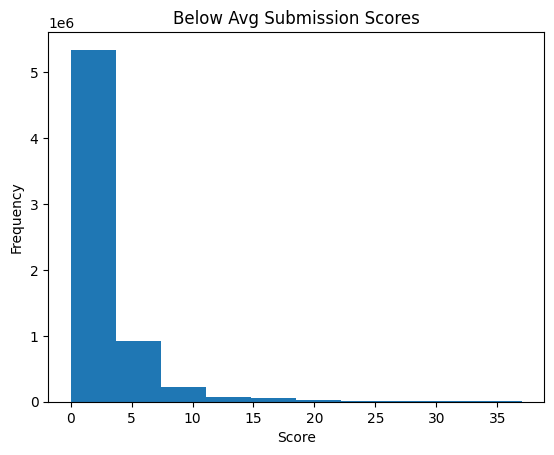

In [31]:
plt.hist(below_avg['score'])
plt.title('Below Avg Submission Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

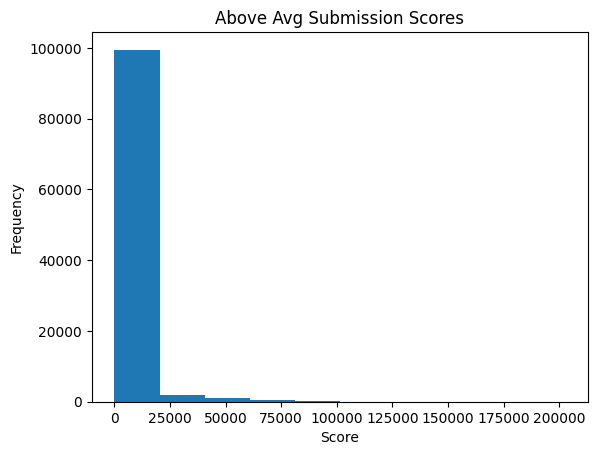

In [32]:
plt.hist(above_avg['score'])
plt.title('Above Avg Submission Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [33]:
# Save the new dataframes
above_avg.to_json('./data-subsets/submissions-above-avg.json.gz', compression='gzip', orient='records', lines=True)
below_avg_sampled.to_json('./data-subsets/submissions-below-avg.json.gz', compression='gzip', orient='records', lines=True)